# AlexNet(Tensorflow)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. Load data set

现在我们已经知道了如何使用Tensorflow的```Dataset```加大数据通过generator的方式加载到内存中,那么我们接下去就使用```Dataset```的方式加载我们需要训练的样本,需要注意的是我们这里还会多做一步操作即:

### [1.1] Split data set

In [3]:
class SplitData:
    """
    Split training data and testing data.
    """
    def __init__(self, file_dir, Load_samples=None, Shuffle=True, test_rate=0.3):
        """
        :param file_dir (string): data dir. like '../train' it's a directory.
        :param Load_samples (int,None): loading Number,if equal None loading all files,default None.
        :param Shuffle (bool): is shuffle original files. suggest True.
        :param test_rate (float): test data rate.
        """
        self.file_dir = file_dir
        self.test_rate = test_rate
        self.Load_samples = Load_samples
        self.Shuffle = Shuffle

    def __call__(self):
        """
        :return train_files, test_files (list): include train files path and test files path.
        """
        # loading all path in current file dir.
        files_list = os.listdir(self.file_dir)

        if self.Shuffle:
            np.random.shuffle(files_list)

        if self.Load_samples is not None:
            files_list = files_list[:self.Load_samples]

        # split data
        len_ = len(files_list)
        test_index = int(np.floor(len_ * self.test_rate))
        test_files = files_list[:test_index]
        train_files = files_list[test_index:]

        # join path
        test_files = [os.path.join(self.file_dir, file) for file in test_files]
        train_files = [os.path.join(self.file_dir, file) for file in train_files]

        train_samples, test_samples = len_ - test_index, test_index
        print('Training Samples:{},Testing Samples:{}'.format(train_samples, test_samples))

        return train_files, test_files

```SplitData```接受以下参数:

- file_dir: 含有所有图片的目录.

- Load_samples: 总共需要加载多少样本,可以选择为None,那么则表示加载所有的图片.

- Shuffle: 是否打乱文件,建议打乱

- test_rate: 测试样本的划分比率.

该类首先依照```file_dir```找到该目录下的所有图片,接着Shuffle图片,当设置了```Load_samples```获取该限制下的量,最后划分train/test.

我们来尝试调用一下

In [4]:
file_dir = '/Users/huwang/Joker/Data_Set/catVSdot/train'
split_data = SplitData(file_dir, Load_samples=100, test_rate=0.3)
train_files, test_files = split_data()
print('Example of train_files:\n',train_files[0])
print('Example of test_files:\n',test_files[0])

Training Samples:70,Testing Samples:30
Example of train_files:
 /Users/huwang/Joker/Data_Set/catVSdot/train/dog.2228.jpg
Example of test_files:
 /Users/huwang/Joker/Data_Set/catVSdot/train/cat.3606.jpg


现在已经能够将原来的数据集划分为train/test的模式,那么我们接下去只要使用```Dataset```创建一个generator即可:

### [1.2] Dataset

In [5]:
class LoadData:
    """
    Load data set.
    have four function:
        1. add_labels: add data label and change input value to nd_array.
        2. parse_images: parse images.
        3. get_batch: create tensorflow data loader. and return generator.
        4. get_data: get batch data set.

    Tensorflow Load Data Tutorial:
        ==> https://www.tensorflow.org/guide/datasets
    """
    def __init__(self, batch_size, sess):
        """
        :param batch_size (int): data batch size.
        :param sess : tensor graph.
        """
        self.batch_size = batch_size
        self.sess = sess

    def add_labels(self, files):
        """
        add image label and change type to ndarray.
        :param files (list): include handle files.
        :return
            features (ndarray): data set.
            labels (ndarray): labels.
        """
        labels = []
        features = []

        for file in files:
            classes = file.split('/')[-1].split('.', 1)[0]
            labels.append([0 if classes == 'dog' else 1])
            features.append([file])

        return np.array(features), np.array(labels)

    def parse_images(self, feature, label):
        """
        parse images.
        1.read file.
        2.decode
        3.resize to (224,224)
        4.pad to (227,227)
        5.normalized to [0-1].

        :param feature (tensor): include image path.
        :param label (tensor): label.
        :return
            image_ones (tensor): parse image result shape is (None,227,227,3)
            label (tensor): parse label result shape is (None,1)
        """
        image_string = tf.read_file(feature[0])
        image_decode = tf.image.decode_jpeg(image_string)
        image_resize = tf.image.resize_images(image_decode, (224, 224))
        # image_normal = tf.image.per_image_standardization(image_resize)
        image_pad = tf.pad(image_resize,([1,2],[1,2],[0,0]))
        image_ones = tf.div(image_pad, 255)

        return image_ones, label

    def get_batch(self, features, labels):
        """
        :param feature (tensor): include image path.
        :param label (tensor): label.

        Note:
            data_set = data_set.repeat():
            ===================================================================
            Infinite get data in sequence.if not set repeat, when the sequence
            is null, gave "End of sequence". means it has traversed the all data
            set.can running the next epoch.
            more information:
            ==>
            https://www.tensorflow.org/guide/datasets#processing_multiple_epochs
            ===================================================================
        """
        features_ = tf.placeholder(features.dtype, features.shape)
        labels_ = tf.placeholder(labels.dtype, labels.shape)

        data_set = tf.data.Dataset.from_tensor_slices((features_, labels_))
        data_set = data_set.map(self.parse_images)
        data_set = data_set.shuffle(1000)
        data_set = data_set.batch(self.batch_size)

        # data_set = data_set.repeat()
        iterator_train = data_set.make_initializable_iterator()
        next_element = iterator_train.get_next()

        # every epoch needs running this code to loading data and shuffled.
        self.sess.run(iterator_train.initializer, feed_dict={features_: features, labels_: labels})

        return next_element

    def get_data(self, files):
        """
        :param feature (tensor): include image path.
        :return next_element (generator):
            it's a generator, running it can get images(batch,227,227,3) and labels(batch,1).
        """
        features, labels = self.add_labels(files)
        next_element = self.get_batch(features, labels)
        return next_element

```LoadData```接受以下参数:

- batch_size: 迭代的batch size.

- sess: Tensorflow graph.

```LoadData```返回一个```next_element```迭代器,需要注意的是,由于我们这里没有使用```repeat()```,那么当sequence为空的时候(也就是说给予的全部样本都已经迭代出来)意味着一次epoch完成,那么在下一次epoch的时候我们需要重新装入数据即:```self.sess.run(iterator_train.initializer, feed_dict={features_: features, labels_: labels})```用来保证训练数据的Shuffle和新的一次迭代.

函数```add_labels```作用为创建label,我们这里选择cat:1,dog:0,并将我们传递进来的train files或者test files和labels统一转换为```ndarray```的形式,方便```get_batch```使用.

这里需要注意的一点是:

> ```image_normal = tf.image.per_image_standardization(image_resize)```我们不会使用,因为```LoadData```是train samples和test samples的统一调口,然而在一般情况下,我们只能标准化/归一化train samples而不能标准化/归一化 test samples/validation samples.

> ![](../../../../../picture/226.png)

> [CS231n](http://cs231n.github.io/neural-networks-2/)

接着,我们来尝试调用:
请注意,我们上一步的train samples为70,这里我们使用的batch size为50,并且我们没有设置```repeat()```所以再两次循环后就会抛出错误.

Images shape:(50, 227, 227, 3), labels shape:(50, 1)


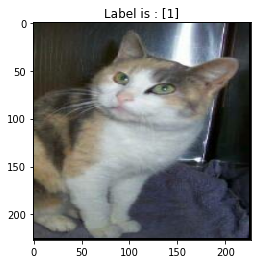

Images shape:(20, 227, 227, 3), labels shape:(20, 1)


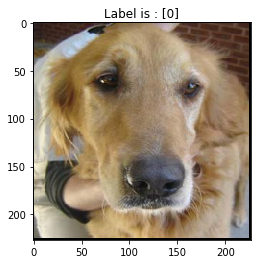

End of sequence


In [7]:
with tf.Session() as sess:
    loader = LoadData(50, sess)
    next_element_train = loader.get_data(train_files)
    while 1:
        try:
            images, labels = sess.run(next_element_train)
            print('Images shape:{}, labels shape:{}'.format(images.shape, labels.shape))
            plt.title('Label is : {}'.format(labels[0]))
            plt.imshow(images[0])
            plt.show()
        except tf.errors.OutOfRangeError:
            print('End of sequence')
            break

## 2. Build Model

在搭建模型的时候,需要注意我并没有采取数据增广的方式,并且也没有download samples and crop to (256).按照paper是需要将裁剪后的训练数据水平镜像翻转来达到增加数据集的目的,还有进行PCA不降维的处理,实际上我之前做过数据增广,然而我只有一块```NVIDIA Tesla K80```还是google免费送我用的,做数据增广之后数据量一下变大了10几倍,训练时间过长,我还要写这些文档,完全没有时间,所以我就不做这些处理了.

下面我们来构建AlexNet模型,整体的框架如下显示:

![](../../../../../picture/182.png)

### [2.1] Initialization Parameters

首先我们依照AlexNet框架初始化$C1-C5$的参数以及$FC$的参数.

由于Tensorflow已经不建议使用```tf.contrib```,那么我们需要手动搭建FC,并且我发现如果使用```tf.contrib```貌似模型就不收敛,我也不知道为什么,可能我模型搭建错误,最终我将其换成自己搭建的FC模型就收敛了.

![](../../../../../picture/227.png)

```python
def init_parameters(self):
        """
        Initialization parameters.

        :return params (tuple): include weights and bias,notice,weights have fully connect layer.
        """
        init_W = tf.initializers.glorot_normal()
        init_b = tf.initializers.zeros()
        # Convolution layers...
        W1 = tf.get_variable('W1', [11, 11, 3, 96], initializer=init_W)
        b1 = tf.get_variable('b1', [1, 1, 96], initializer=init_b)
        W2 = tf.get_variable('W2', [5, 5, 96, 256], initializer=init_W)
        b2 = tf.get_variable('b2', [1, 1, 256], initializer=init_b)
        W3 = tf.get_variable('W3', [3, 3, 256, 384], initializer=init_W)
        b3 = tf.get_variable('b3', [1, 1, 384], initializer=init_b)
        W4 = tf.get_variable('W4', [3, 3, 384, 384], initializer=init_W)
        b4 = tf.get_variable('b4', [1, 1, 384], initializer=init_b)
        W5 = tf.get_variable('W5', [3, 3, 384, 256], initializer=init_W)
        b5 = tf.get_variable('b5', [1, 1, 256], initializer=init_b)

        # Fully connect layers....
        W6 = tf.get_variable('W6', [6*6*256, 4096], initializer=init_W)
        b6 = tf.get_variable('b6', [1, 4096], initializer=init_b)
        W7 = tf.get_variable('W7', [4096, 4096], initializer=init_W)
        b7 = tf.get_variable('b7', [1, 4096], initializer=init_b)
        W8 = tf.get_variable('W8', [4096, self.n_classes], initializer=init_W)
        b8 = tf.get_variable('b8', [1, self.n_classes], initializer=init_b)
        params = (W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, W7, b7, W8, b8)

        return params```

依照paper原文,需要使用SGD,学习率0.01,batch size是128,momentum为0.9,weight decay为0.0005(论文有个权重更新公式),每当validation error不再下降时,学习率除以10.权重初始化用(0，0.01)的高斯分布,二四五卷积层和全连接层的bias初始化为1(给relu提供正值利于加速前期训练),其余bias初始化为0.

<span style="color:red">我这里没有按照paper的方式,因为我这里的数据量太小,如果严格按照paper的做法模型收敛会很慢,甚至到20几个epoch的时候完全不收敛.</span>

### [2.2] Forward

```python
    def forward(self, data, params,rate):
        """
        forward propagation.
        :param data (tensor): training data set.
        :param params (tuple,tensor): weights and bias.
        :param rate (float): dropout rate.
        :return out (tensor): forward result, the shape is (batch,n_classes).
        """
        W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, W7, b7, W8, b8 = params
        #CONV1
        C1 = self._Conv(data, W1, b1, [1, 4, 4, 1], "VALID", 'Conv_1')
        R1 = tf.nn.relu(C1)
        P1 = self._Pool(R1, [1, 3, 3, 1], [1, 2, 2, 1], 'VALID', 'Pool_1')
        L1 = self._Lrn(P1, 'LRN_1')
        #CONV2
        C2 = self._Conv(L1, W2, b2, [1, 1, 1, 1], 'SAME', 'Conv_2')
        R2 = tf.nn.relu(C2)
        P2 = self._Pool(R2, [1, 3, 3, 1], [1, 2, 2, 1], 'VALID', 'Pool_2')
        L2 = self._Lrn(P2, 'LRN_2')
        #CONV3
        C3 = self._Conv(L2, W3, b3, [1, 1, 1, 1], 'SAME', 'Conv_3')
        R3 = tf.nn.relu(C3)
        #CONV4
        C4 = self._Conv(R3, W4, b4, [1, 1, 1, 1], 'SAME', 'Conv_4')
        R4 = tf.nn.relu(C4)
        #CONV5
        C5 = self._Conv(R4, W5, b5, [1, 1, 1, 1], 'SAME', 'Conv_5')
        R5 = tf.nn.relu(C5)
        P5 = self._Pool(R5,[1,3,3,1],[1,2,2,1],'VALID','Pool_5')
        # flatten
        flatten = tf.reshape(P5,[-1,6*6*256])
        #FC6
        F6 = self._Fc(flatten,W6,b6)
        R6 = tf.nn.relu(F6)
        D6 = self._Drop(R6,rate=rate)
        #FC7
        F7 = self._Fc(D6,W7,b7)
        R7 = tf.nn.relu(F7)
        D7 = self._Drop(R7,rate=rate)
        #Out
        out = self._Fc(D7,W8,b8)

        return out```




forward就不多说了,按照模型搭建就好,需要注意的是在```out layer```我们不能使用Activation.因为我们的```Cost function```定义为:

```python
Cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=out,labels=labels))```

## 3. Model

现在我们来创建Model,我们可以使用```saver = tf.train.Saver()```来保存模型,由于我们要保存```out```作为预测时候的运行函数,所以我们需要使用```tf.add_to_collection('pre_network',out)```来增加collection.

更多关于模型保存与加载请看[Save and Restore](https://www.tensorflow.org/guide/saved_model)

模型分为5个步骤:

#### [3.1] Create placeholder

```python
# create placeholder
data = tf.placeholder(tf.float32,[None,227,227,3],name='Input')
labels = tf.placeholder(tf.float32,[None,1],name='Labels')
rate = tf.placeholder(tf.float32,name='rate')```

```data```用于装数据,```labels```用于装标签,```rate```用于```Dropout layer```,其等于$rate=1-keep\;prob$

#### [3.2] build cost and optimizer


```python
params = self.init_parameters()
out = self.forward(data,params,rate)
Cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=out,labels=labels))
optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(Cost)```

使用```RMSPropOptimizer```激活器,并极小Cost,因为对于梯度下降而言极大似然函数可以看出极小经验损失.

#### [3.3] score

```python
predict = tf.round(tf.sigmoid(out))
equal = tf.equal(labels,predict)
correct = tf.cast(equal,tf.float32)
accuracy = tf.reduce_mean(correct)```

这一步就是普通的计算正确率,就不多讲了.

#### [3.4] split date

```python

split_data = SplitData(self.file_dir, Load_samples=self.Load_samples, test_rate=self.test_rate)
        train_files, test_files = split_data()

self.N_train = len(train_files) //  self.batch_size
self.N_test = len(test_files) // self.batch_size```

按照我们之前定义的split data划分数据集即可.

#### [3.5] traing

```python
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        loader = LoadData(self.batch_size, sess)
        next_element_train = loader.get_data(train_files)
        # running all training set...
        count = 1
        while 1:
            try:
                images, target = sess.run(next_element_train)
                print('Training {}/{} \r'.format(count, self.N_train), end='', flush=True)
                count += 1
            except tf.errors.OutOfRangeError:
                break
            else:
                _ = sess.run(optimizer,feed_dict={data:images,labels:target,rate:drop_rate})

        acc_train,loss_train = self.Caculate(sess,train_files,accuracy,Cost,data,labels,rate,'train')
        acc_test, loss_test = self.Caculate(sess, test_files, accuracy, Cost, data, labels,rate,'test')
        print('[{}/{}] train loss:{:.4f} - train acc:{:.4f} - test loss:{:.4f} - test acc:{:.4f}'.format(
            epoch+1,epochs,loss_train,acc_train,loss_test,acc_test
        ))
        if acc_train >= 0.980:
            break```

每次开始一个```epoch```则从新加载一次数据,当```while```执行完毕则表示所有的train samples 已经训练完一次,接着就可以在当前```epoch```下计算正确率,最后如果正确率达到我们的精度要求$0.980$迭代停止,后面的结果可以看到,模型处于过拟合状态,实际上我这里设置$0.980$是为了后面ZFNet的CNN visualization即神经网络可视化.

```self.Caculate```函数是用来score train/test的平均损失和正确率的,因为计算损失和正确率我们依然是使用generator的方式.

#### [3.6] saver

```python
saver.save(sess, 'model/alexNet')```

保存模型在当前目录下的```model```目录.

以上就是AlexNet Model所有步骤,完整代码请查看[AlexNet](AlexNet(Tensorflow).py)

### 4. Model Training in Google Cloud

由于模型训练样本过大,我们将其push到Google cloud进行训练,为了模型训练方便,我们写一个简单的shell脚本Model.sh

```sh
#!/bin/bash
python3 AlexNet\(Tensorflow\).py >> AlexNet_rest.txt

echo "password" | sudo shutdown -h now

```

首先运行```AlexNet(Tensorflow).py```文件,结束之后关闭VM实例.

那么运行shell脚本之后的结果为:

<img src="alexnet.png" height=500 width=500>

可以看到top-5的正确率为$80\%$,最终在20个epoch的时候train accuracy:$98\%$,test accuracy $0.88\%$,模型处于过拟合.

另外这里可以有一个小心机出自[cs231n-Before learning: sanity checks Tips/Tricks](http://cs231n.github.io/neural-networks-3/):

<img src="../../../../../picture/228.png" height=500 width=500>

意思就是说,在使用小参数进行初始化时,确保得到的损失值与期望一致.如果使用softmax,那么我们会期望初始每一类的概率为0.1,那么损失函数的值应该接近$-ln(0.1)=2.302$,而我们这里是2分类,那么$-ln(0.5)=0.69$左右.不要问我为什么.

训练完毕之后会产生一个model的文件夹,其目录为:

<img src="../../../../../picture/207.png" height=300 width=300>

### 5. Predict

现在我们已经有了训练完毕的Model文件,现在我们需要将其加载进来进行预测.

在AlexNet中,测试阶段输入一张$(256,256)$的图片,取其4个角(left_up,right_up,left_bottom,right_bottom)以及中心(center),然后将其水平翻转得到(left_up_transpose,right_up_transpose,left_bottom_transpose,right_bottom_transpose,center_transpose)共计10个样本进行测试,再将这10个样本pad到$(227,227)$,最后获得类别概率值.

**Ps:**

> 这里处理图片的库我们选用PIL,因为其resize功能做的比较好,当然也可以使用matplotlib,skimage,甚至是tf.image.resize.

> 更多关于PIL库的Image请查看[Image](https://pillow.readthedocs.io/en/stable/reference/Image.html)

> resiz_image.crop函数接受(left,up,right,bottom),其(0,0)点位于左上角,建议填写的时候按照[left,right]和[up,bottom]的顺序填写.

在加载TF保存模型的时候有两种方法:

1. 直接保存变量,不好的是我们需要重新定义一次Forward代码,这显然是无用功.

2. 使用meta文件中已经保存的Grah重新计算Forward.这是我们应该选择的方法

这里有篇详细教程[TensorFlow 模型保存/载入的两种方法](https://blog.csdn.net/thriving_fcl/article/details/71423039)可以帮助你.

In [16]:
def Predict(model_dir,picture_path):
    """
    Implemention Predict Image.
    
    Argus:
    -----
        model_dir: Tensorflow saver model dir path. it's like 'model_/alexnet'.
        picture_path: precit picture path.
    """
    
    from PIL import Image
    
    Predict_image = np.zeros((10,224,224,3))
    
    image = Image.open(picture_path)
    resiz_image = image.resize((256,256))
    # left up
    left_up = resiz_image.crop((0,0,224,224)) # (left,up,right,bottom).
    left_up_transpose = left_up.transpose(Image.FLIP_LEFT_RIGHT)
    Predict_image[0,...] += np.array(left_up)
    Predict_image[1,...] += np.array(left_up_transpose)
    # right up
    right_up = resiz_image.crop((256-224,0,256,224))
    right_up_transpose= right_up.transpose(Image.FLIP_LEFT_RIGHT)
    Predict_image[2,...] += np.array(right_up)
    Predict_image[3,...] += np.array(right_up_transpose)
    # left bottom
    left_bottom = resiz_image.crop((0,256-224,224,256))
    left_bottom_transpose = left_bottom.transpose(Image.FLIP_LEFT_RIGHT)
    Predict_image[4,...] += np.array(left_bottom)
    Predict_image[5,...] += np.array(left_bottom_transpose)
    # right bottom
    right_bottom = resiz_image.crop((256-224,256-224,256,256))
    right_bottom_transpose = right_bottom.transpose(Image.FLIP_LEFT_RIGHT)
    Predict_image[6,...] += np.array(right_bottom)
    Predict_image[7,...] += np.array(right_bottom_transpose)
    # center
    pixe_ = 256-224
    center = resiz_image.crop((pixe_/2,pixe_/2,256-pixe_/2,256-pixe_/2))
    center_transpose = center.transpose(Image.FLIP_LEFT_RIGHT)
    Predict_image[8,...] += np.array(center)
    Predict_image[9,...] += np.array(center_transpose)
    
    
    # Get Save Model
    tf.reset_default_graph()
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph(model_dir+'.meta')
        new_saver.restore(sess, model_dir)
        # tf.get_collection() return a list.
        out = tf.get_collection('pre_network')[0]

        graph = tf.get_default_graph() 
        
        # get Variable X by tensor name.
        X = graph.get_operation_by_name('Input').outputs[0]
        # get Variable rate by tensor name.
        # Notic, we do not load Variable y !.
        rate = graph.get_operation_by_name('rate').outputs[0]
        
        # pad data to shape (227,227)
        data = np.pad(Predict_image,pad_width=((0,0),(1,2),(1,2),(0,0)),mode='constant')
        data = data /  255
        # predict
        OUT = sess.run(out,feed_dict={X:data,rate:0})
        sigmoid_out = 1./(1+np.exp(-OUT))
        roud_ = np.round(sigmoid_out)
        classes_cat_rate = np.sum(roud_) /  10
        classes_dog_rate = 1-classes_cat_rate
        
        print('The picture is cat rate: {:.4f} %'.format(classes_cat_rate*100))
        print('The picture is dog rate: {:.4f} % '.format(classes_dog_rate*100))
            

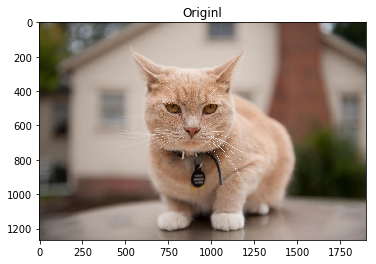

INFO:tensorflow:Restoring parameters from model/alexNet
The picture is cat rate: 100.0000 %
The picture is dog rate: 0.0000 % 


In [17]:
model_dir = 'model/alexNet'
picture_path = 'cat.jpg'
img_test = plt.imread(picture_path)
plt.imshow(img_test)
plt.title('Originl')
plt.show()
Predict(model_dir,picture_path)

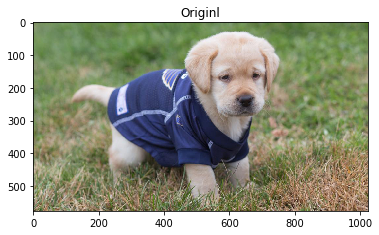

INFO:tensorflow:Restoring parameters from model/alexNet
The picture is cat rate: 0.0000 %
The picture is dog rate: 100.0000 % 


In [19]:
model_dir = 'model/alexNet'
picture_path = 'dog.jpg'
img_test = plt.imread(picture_path)
plt.imshow(img_test)
plt.title('Originl')
plt.show()
Predict(model_dir,picture_path)